# XGBoost

## Importar las librerías

In [21]:
import pandas as pd

## Importar el conjunto de datos

In [22]:
datos = pd.read_csv('HALF_DATA.csv')
X = datos.iloc[:, :-1].values
y = datos.iloc[:, -1].values

In [23]:
#label encoding y
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

## División del conjunto de datos en un subconjunto para entrenamiento y otro para pruebas

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Limites para los hiperparametros

In [25]:
param_limits = {
    'n_estimators': (50, 200, 'int'),
    'max_depth': (3, 10, 'int'),
    'learning_rate': (0.01, 0.3, 'float'),
    'subsample': (0.5, 1.0, 'float')
}

## Fitness function para obtener un score númerico

In [26]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

def fitness_function(individual):
    modelo = XGBClassifier(
        n_estimators=individual['n_estimators'],
        max_depth=individual['max_depth'],
        learning_rate=individual['learning_rate'],
        subsample=individual['subsample'],
        use_label_encoder=False,
        eval_metric='logloss'
    )

    puntuacion = cross_val_score(modelo, X_train, y_train, cv=3, scoring='accuracy').mean()
    return puntuacion

## Instancia del optimizador genético

In [29]:
from optimizer import GeneticAlgorithmOptimizer

optimizer = GeneticAlgorithmOptimizer(
    param_limits=param_limits,
    fitness_function=fitness_function,
    population_size=3,
    generations=20,
    crossover_rate=0.8,
    mutation_rate=0.2,
    tournament_size=3,
    verbose=True
)

In [30]:
import warnings
warnings.filterwarnings('ignore')

best_params, best_score = optimizer.run()

Generation 1/20
Best score so far: 0.9736
Generation 2/20
Best score so far: 0.9772
Generation 3/20
Best score so far: 0.9772
Generation 4/20
Best score so far: 0.9782
Generation 5/20
Best score so far: 0.9782
Generation 6/20
Best score so far: 0.9782
Generation 7/20
Best score so far: 0.9793
Generation 8/20
Best score so far: 0.9793
Generation 9/20
Best score so far: 0.9793
Generation 10/20
Best score so far: 0.9793
Generation 11/20
Best score so far: 0.9793
Generation 12/20
Best score so far: 0.9793
Generation 13/20
Best score so far: 0.9793
Generation 14/20
Best score so far: 0.9795
Generation 15/20
Best score so far: 0.9795
Generation 16/20
Best score so far: 0.9795
Generation 17/20
Best score so far: 0.9816
Generation 18/20
Best score so far: 0.9816
Generation 19/20
Best score so far: 0.9816
Generation 20/20
Best score so far: 0.9816


## Obtener la Matriz de Confusión con los mejores hiperparámetros

In [31]:
classifier = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    use_label_encoder=False,
    eval_metric='logloss'
)
classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.22804611582292109, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=161, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_predicciones = classifier.predict(X_test)
mat_conf = confusion_matrix(y_test, y_predicciones)
print(mat_conf)
accuracy_score(y_test, y_predicciones)

[[42  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  2  0  0  0 33  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  0  0  2 31  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  0  0  0  0 34  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 33  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 35  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  0  0  

0.984472049689441

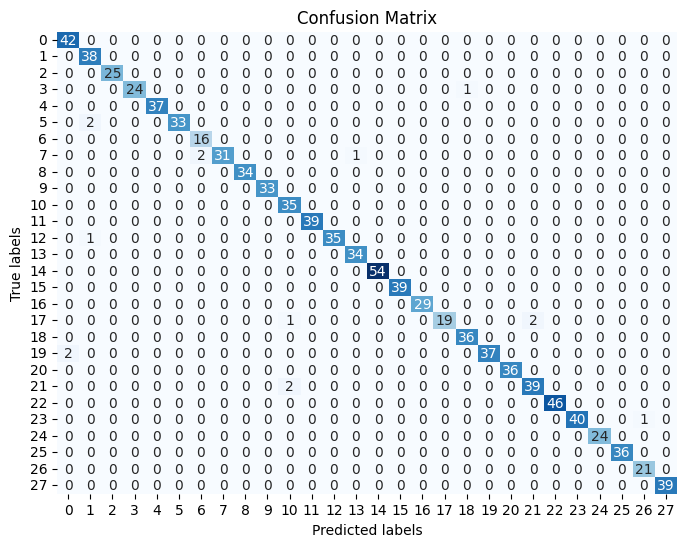

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(mat_conf, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()